In [1]:
!pip install nilearn nibabel tqdm PCAonGPU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 20.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import nibabel as nib
# import nibabel.testing import data_path
from nilearn import image
from nilearn import datasets
from nilearn import plotting
import gzip
import torch
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_dir = "/content/drive/MyDrive/CS545/"

In [5]:
subtasks = ['sub-001/', 'sub-002/', 'sub-003/', 'sub-004/', 'sub-005/']

In [6]:
folder = 'func/'

In [ ]:
os.path.exists("/content/drive/MyDrive/CS545/sub-003/func/sub-003_task-Test_run-01_bold.nii")

True

In [ ]:
# save_file_dir = "/content/drive/MyDrive/CS545_PCA_Datasets/"
# for subject in subtasks:
#   full_dir_name = file_dir + subject + folder
#   for file in tqdm(os.listdir(full_dir_name)):
#       # check only text files
#       if file.endswith('.nii'):
#           img = image.load_img(full_dir_name + file)
#           img_np = image.get_data(img).astype(np.float64)
#           img_torch = torch.from_numpy(img_np).reshape(-1, 410)
#           v = torch.pca_lowrank(img_torch)
#           torch.save(v, save_file_dir+subject+file[:-4] + ".pt")


100%|██████████| 54/54 [06:35<00:00,  7.32s/it]


In [ ]:
from pathlib import Path
import shutil

save_file_dir = "/content/drive/MyDrive/dataset_splits"
test_label_file_dir = "/content/drive/MyDrive/dataset_splits/test/labels"
test_data_file_dir = "/content/drive/MyDrive/dataset_splits/test/data"
train_label_file_dir = "/content/drive/MyDrive/dataset_splits/train/labels"
train_data_file_dir = "/content/drive/MyDrive/dataset_splits/train/data"


# a new song is played every 15 seconds, therefore we want to split each fmri scan into
# {#songs} even segments across time (hopefully comes out to 15 seconds) to get independent scans for each song

# clear all existing files
def clear_existing_files():
  shutil.rmtree(test_data_file_dir)
  shutil.rmtree(train_data_file_dir)
  os.remove(test_label_file_dir)
  os.remove(train_label_file_dir)


# returns ordered labels
def get_genres_from_tsv(tsv_filepath):
  genres = []
  df = pd.read_csv(tsv_filepath, sep="\t")
  for genre in df['genre']:
    genres.append(genre[1:len(genre)-1])
  return genres

# split image into genre segments
def segment(img_np, n_segments):
  return np.split(img_np, n_segments, axis=-1)

# retrieve run number from file name
def get_run_number(file):
      # get run number
      suffix = file.split('-')[-1]
      topic = suffix.split('.')[0]
      run_number = int(topic.split('_')[0])
      return run_number

def write_segment(name, segment, label, data_path, label_path):
  np.save(os.path.join(data_path, name), segment)
  with open(os.path.join(label_path, name), "w+") as f:
    f.write(label)

def write_train_test_run(filename_prefix, segments, labels, train_percentage=0.8):
  n_samples = len(labels)

  for i in range(n_samples):
    sample, label = segments[i], labels[i]
    filename = filename_prefix + '_' + label
    if np.random.random() <= train_percentage:
      write_segment(filename, sample, label, train_data_file_dir, train_label_file_dir)
    else:
      write_segment(filename, sample, label, test_data_file_dir, test_label_file_dir)


def split_train_test(train_percentage=0.8):
  # run to data/label
  # collect labels
  subject_i = 0
  for subject in tqdm(subtasks):
    runs_to_labels = {}
    full_dir_name = file_dir + subject + folder

    for file in os.listdir(full_dir_name):
      run_number = get_run_number(file)
      # get labels
      if file.endswith(".tsv"):
        genres = get_genres_from_tsv(full_dir_name + file)
        n_segments = len(genres)
        runs_to_labels[run_number] = genres

    for file in os.listdir(full_dir_name):
      run_number = get_run_number(file)
      # check only text files
      if file.endswith('.nii'):
        img = image.load_img(full_dir_name + file)
        img_np = image.get_data(img).astype(np.float64)
        segments = segment(img_np, n_segments)

        segment_prefix = str(subject_i) + '_' + str(run_number)
        write_train_test_run(segment_prefix, segments, runs_to_labels[run_number], train_percentage=train_percentage)

    subject_i += 1


In [44]:
num_components = 150

In [46]:
# prompt: Use PCAOnGPU to perform Incremental PCA on each .npy file under the file directory "/content/drive/MyDrive/dataset_splits/train/data". Each numpy array is 4 dimensions that we need to reshape into 2D by flattening the first 3 dimensions

from gpu_pca import IncrementalPCAonGPU
import numpy as np
import os
import torch
from tqdm import tqdm

# create PCAOnGPU object
pca = IncrementalPCAonGPU(n_components=num_components)
file_path = "/content/drive/MyDrive/dataset_splits/train/data/"
# fit PCAOnGPU to each file

for file in tqdm(os.listdir(file_path)):
  # load numpy array
  data = np.load(file_path + file)
  # reshape array to 2D
  data = data.reshape(-1, data.shape[-1]).T
  # Convert to a PyTorch tensor
  data = torch.from_numpy(data)

  # Move the tensor to the GPU
  if torch.cuda.is_available():
      data = data.to('cuda')
  # fit PCAOnGPU
  pca.partial_fit(data)



# save PCAOnGPU model
torch.save(pca, "/content/drive/MyDrive/dataset_splits/pca_weights/only_train_" + str(num_components)+ "_pca_weights.pt")


100%|██████████| 615/615 [29:28<00:00,  2.88s/it]


In [58]:
file_path = "/content/drive/MyDrive/dataset_splits/train/data/"
# fit PCAOnGPU to each file
def pca_transformation(pca, file_path, save_path):
  for file in tqdm(os.listdir(file_path)):
    # load numpy array
    data = np.load(file_path + file)
    # reshape array to 2D
    data = data.reshape(-1, data.shape[-1]).T
    # Convert to a PyTorch tensor
    data = torch.from_numpy(data)

    # Move the tensor to the GPU
    if torch.cuda.is_available():
        data = data.to('cuda')
    # transform PCAOnGPU
    torch.save(pca.transform(data), save_path + 'transformed_' + file.split('.')[0] + ".pt")

NotImplementedError: ignored

In [9]:
pca = torch.load("/content/drive/MyDrive/dataset_splits/pca_weights/only_train_" + str(num_components)+ "_pca_weights.pt")

In [63]:
pca_transformation(pca, file_path = "/content/drive/MyDrive/dataset_splits/train/data/", save_path = '/content/drive/MyDrive/dataset_splits/train/data_pca/transformed_' + str(pca.n_components) + '/')

100%|██████████| 615/615 [13:17<00:00,  1.30s/it]


In [64]:
pca.components_.shape

torch.Size([150, 626688])

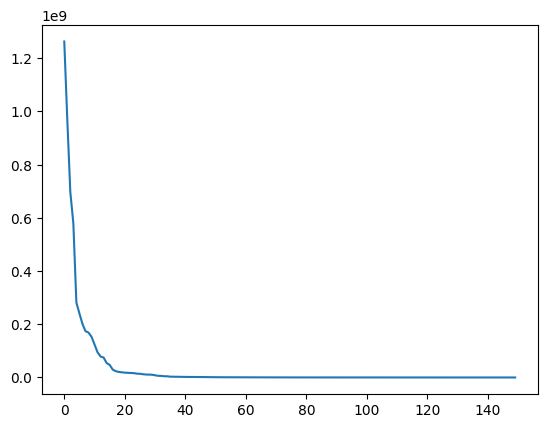

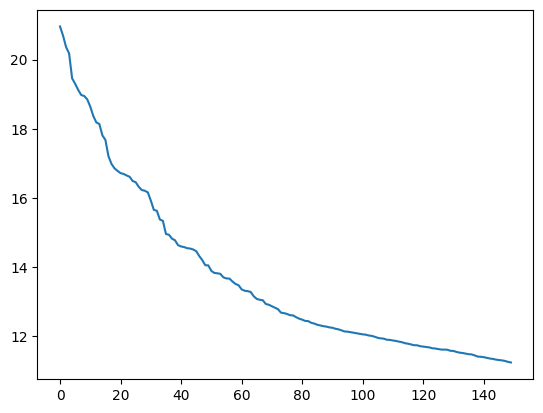

In [65]:
import matplotlib.pyplot as plt
plt.plot(pca.explained_variance_.cpu().numpy())
plt.show()
plt.plot(np.log(pca.explained_variance_.cpu().numpy()))
plt.show()

In [ ]:
comp = pca.components_

In [ ]:
comp = comp.reshape((, 96, 96, 68)).permute(1,2,3,0)
comp.shape

torch.Size([96, 96, 68, 30])

In [66]:
transformed_folder = '/content/drive/MyDrive/dataset_splits/train/data_pca/transformed_' + str(pca.n_components) + '/'

In [68]:
genres = {
    'ues': 'blues',
    'cal': 'classical',
    'gae': 'reggae',
    'ock': 'rock',
    'pop': 'pop',
    'hop': 'hiphop',
    'tal': 'metal',
    'azz': 'jazz',
    'try': 'country',
    'sco': 'disco'
}

genre_count = {}
total_count = 0
for file in tqdm(os.listdir(transformed_folder)):
  if file.endswith('.pt'):
    genre_suffix = file.split('.')[0][-3:]
    if genre_suffix not in genres:
      print(genre_suffix, "not in genres!")
      continue
    if genres[genre_suffix] not in genre_count:
      genre_count[genres[genre_suffix]] = 0
    genre_count[genres[genre_suffix]] += 1
    total_count += 1
print(genre_count)
print(total_count)


100%|██████████| 615/615 [00:00<00:00, 788354.82it/s]

{'rock': 60, 'blues': 60, 'disco': 60, 'jazz': 65, 'pop': 60, 'metal': 65, 'classical': 65, 'hiphop': 60, 'country': 60, 'reggae': 60}
615


In [70]:
label_list = []
train_pca_combined = torch.Tensor([]).to('cuda')
for file in tqdm(os.listdir(transformed_folder)):
  if file.endswith('.pt'):
    genre_suffix = file.split('.')[0][-3:]
    label_list.append(genres[genre_suffix])

    data = torch.load(transformed_folder + file)
    # Reshape data to 2D tensor if not already
    data = data.view(-1, data.shape[0] * data.shape[1])
    # Concatenate
    if train_pca_combined is None:
        train_pca_combined = data
    else:
        train_pca_combined = torch.cat((train_pca_combined, data), dim=0)  # Concatenating along the first dimension
label_list = np.array(label_list)



train_pca_combined.shape

100%|██████████| 615/615 [00:32<00:00, 18.90it/s] 


torch.Size([615, 1500])

In [71]:
print(label_list)

['rock' 'blues' 'disco' 'jazz' 'pop' 'metal' 'classical' 'hiphop'
 'country' 'reggae' 'jazz' 'reggae' 'blues' 'disco' 'hiphop' 'metal' 'pop'
 'country' 'classical' 'rock' 'classical' 'reggae' 'country' 'pop' 'jazz'
 'rock' 'metal' 'blues' 'disco' 'hiphop' 'disco' 'country' 'classical'
 'jazz' 'metal' 'pop' 'reggae' 'hiphop' 'blues' 'rock' 'classical' 'metal'
 'jazz' 'reggae' 'country' 'metal' 'hiphop' 'classical' 'disco' 'jazz'
 'blues' 'pop' 'rock' 'reggae' 'blues' 'classical' 'jazz' 'country'
 'country' 'hiphop' 'disco' 'reggae' 'metal' 'rock' 'blues' 'metal'
 'classical' 'hiphop' 'disco' 'jazz' 'pop' 'rock' 'country' 'reggae'
 'metal' 'pop' 'rock' 'hiphop' 'disco' 'blues' 'jazz' 'classical' 'pop'
 'blues' 'country' 'reggae' 'hiphop' 'disco' 'rock' 'classical' 'metal'
 'pop' 'jazz' 'classical' 'metal' 'country' 'reggae' 'disco' 'blues' 'pop'
 'hiphop' 'rock' 'jazz' 'classical' 'blues' 'rock' 'reggae' 'country'
 'jazz' 'hiphop' 'pop' 'metal' 'disco' 'reggae' 'classical' 'metal'
 'hiph

In [72]:
x = train_pca_combined.reshape((15,41,1500))
x.shape

torch.Size([15, 41, 1500])

In [73]:
priors = []
for genre in genre_count:
  priors.append(genre_count[genre] / total_count)
priors

[0.0975609756097561,
 0.0975609756097561,
 0.0975609756097561,
 0.10569105691056911,
 0.0975609756097561,
 0.10569105691056911,
 0.10569105691056911,
 0.0975609756097561,
 0.0975609756097561,
 0.0975609756097561]

In [16]:
!pip install torch-kmeans

In [74]:
import torch
from torch_kmeans import KMeans

model = KMeans(n_clusters=len(priors))

result = model(x)
output_labels = result.labels.reshape(total_count)
print(output_labels)

Full batch converged at iteration 8/100 with center shifts = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', dtype=torch.float64).
tensor([7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 6, 4, 4, 4, 6, 0, 3, 3, 6, 6, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 2, 1, 1, 1, 2, 2, 5, 5, 5, 5, 5, 2, 2, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 8, 9, 8, 5, 7, 8, 7, 7, 5, 5, 5, 5, 9, 7, 3, 3, 3, 9, 9,
        4, 6, 6, 6, 4, 6, 4, 6, 4, 6, 6, 1, 9, 9, 9, 1, 9, 9, 1, 9, 1, 0, 0, 0,
        0, 0, 4, 0, 0, 4, 0, 3, 7, 3, 7, 8, 7, 7, 7, 3, 3, 5, 5, 2, 2, 5, 2, 5,
        5, 5, 5, 3, 4, 9, 5, 9, 4, 2, 5, 3, 2, 1, 6, 6, 6, 1, 1, 6, 6, 1, 8, 8,
        6, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 1, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 8, 2, 2, 2, 8, 3, 3, 3, 3, 8, 8, 3, 2, 3,
        3, 3, 3, 4, 7, 4, 7, 5, 5, 5, 5, 7, 9, 2, 2, 3, 2, 6, 6, 2, 2, 2, 4, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 7, 7, 0, 7, 7, 7, 7, 7, 7, 4, 9, 9, 9, 1,
        1, 9, 5, 1, 9, 5

In [75]:
output_labs = output_labels.cpu().numpy()
cluster_indices = {i:np.argwhere((output_labs == i) == 1).flatten() for i in range(len(priors))}
print(cluster_indices)

{0: array([ 15,  43,  44,  45,  46,  47,  93,  94,  95,  96,  97,  99, 100,
       102, 153, 154, 156, 157, 158, 159, 160, 161, 162, 164, 165, 225,
       228, 271, 272, 274, 292, 295, 299, 300, 351, 352, 354, 355, 357,
       369, 370, 371, 372, 376, 412, 413, 414, 415, 416, 417, 418, 419,
       420, 421, 483, 484, 506, 508, 510, 511, 545, 546, 547, 548, 549,
       551, 552, 605, 607, 608]), 1: array([ 31,  32,  33,  48,  49,  50,  51,  52,  83,  87,  90,  92, 133,
       137, 138, 141, 166, 239, 240, 243, 257, 258, 264, 305, 332, 333,
       335, 337, 338, 339, 399, 400, 401, 402, 403, 444, 445, 448, 474,
       475, 479, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 565,
       566, 567, 568, 569, 570, 571, 572, 573, 579, 580, 581, 584]), 2: array([ 30,  34,  35,  41,  42, 115, 116, 118, 129, 132, 176, 177, 179,
       180, 181, 190, 205, 206, 208, 211, 212, 213, 246, 247, 248, 249,
       250, 251, 252, 253, 254, 255, 301, 304, 307, 308, 310, 359, 360,
       361, 363, 365, 3

In [79]:
from statistics import mode
for cluster in cluster_indices:
  print(label_list[cluster_indices[cluster]])


['metal' 'reggae' 'country' 'metal' 'hiphop' 'classical' 'classical'
 'metal' 'country' 'reggae' 'disco' 'pop' 'hiphop' 'jazz' 'reggae' 'rock'
 'country' 'hiphop' 'metal' 'jazz' 'pop' 'blues' 'classical' 'classical'
 'metal' 'classical' 'country' 'metal' 'classical' 'country' 'classical'
 'metal' 'rock' 'hiphop' 'reggae' 'jazz' 'pop' 'metal' 'disco' 'disco'
 'reggae' 'jazz' 'hiphop' 'metal' 'metal' 'blues' 'pop' 'country' 'hiphop'
 'reggae' 'disco' 'rock' 'jazz' 'classical' 'classical' 'metal' 'pop'
 'country' 'classical' 'blues' 'country' 'metal' 'classical' 'rock' 'pop'
 'blues' 'reggae' 'metal' 'pop' 'disco']
['country' 'classical' 'jazz' 'disco' 'jazz' 'blues' 'pop' 'rock' 'blues'
 'disco' 'metal' 'jazz' 'country' 'blues' 'hiphop' 'jazz' 'classical'
 'hiphop' 'pop' 'country' 'metal' 'country' 'classical' 'rock' 'metal'
 'rock' 'reggae' 'disco' 'blues' 'pop' 'blues' 'classical' 'metal' 'jazz'
 'disco' 'pop' 'rock' 'jazz' 'disco' 'reggae' 'pop' 'rock' 'jazz' 'pop'
 'reggae' 'disco' '

/usr/local/lib/python3.10/dist-packages/nilearn/plotting/displays/_slicers.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(figure, figsize=figsize, facecolor=facecolor)


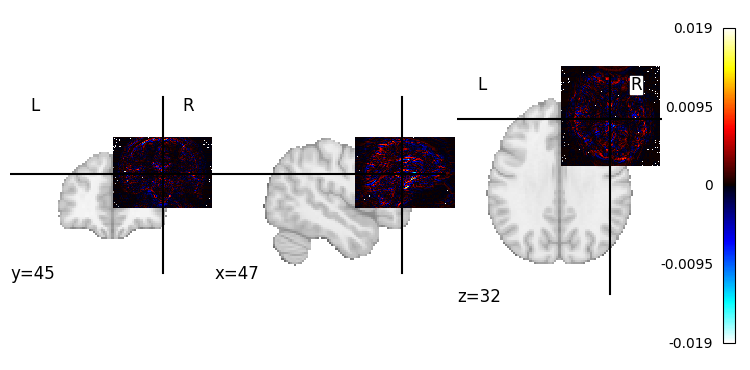

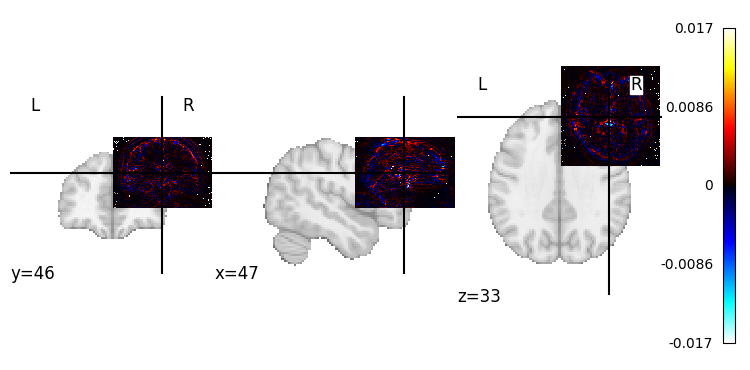

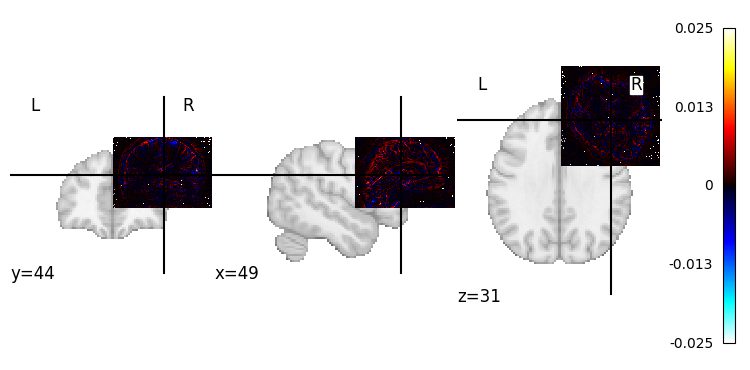

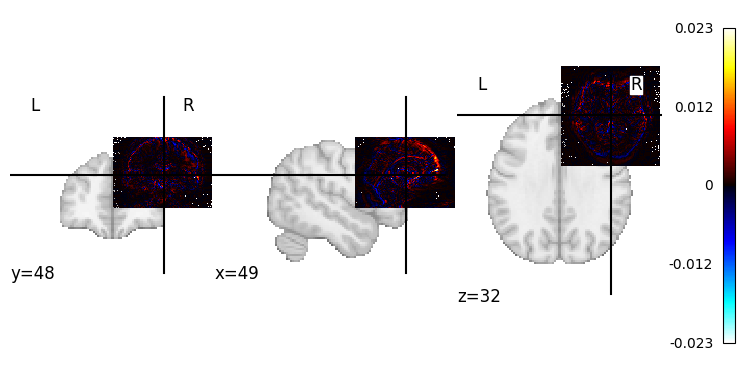

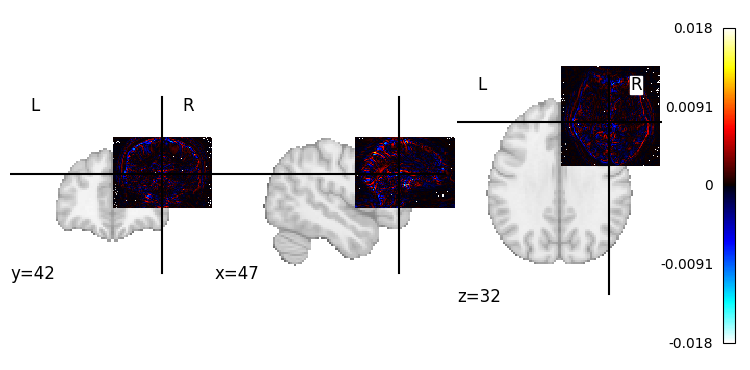

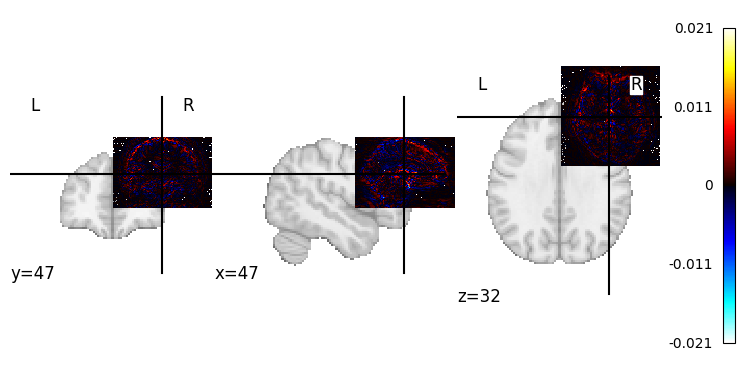

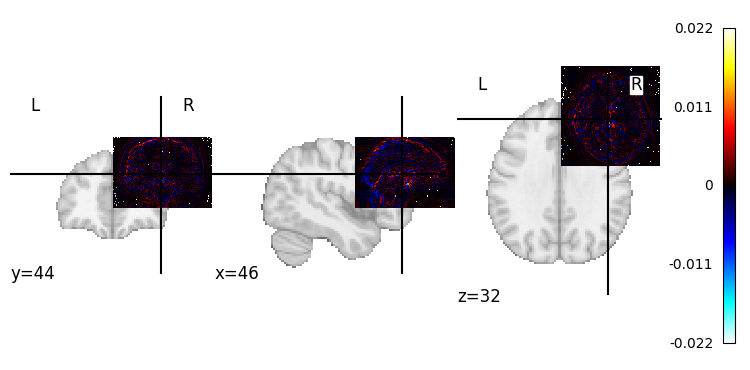

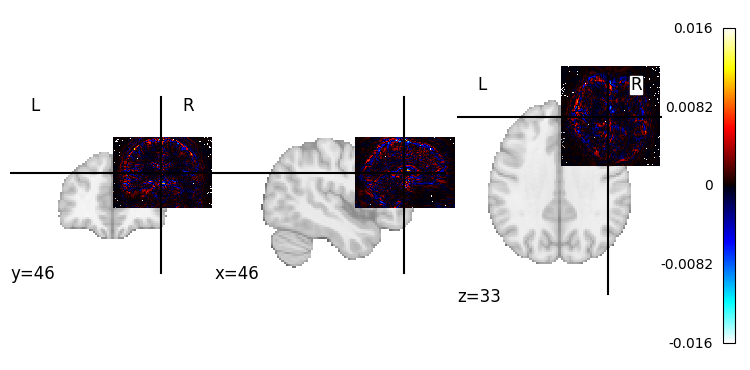

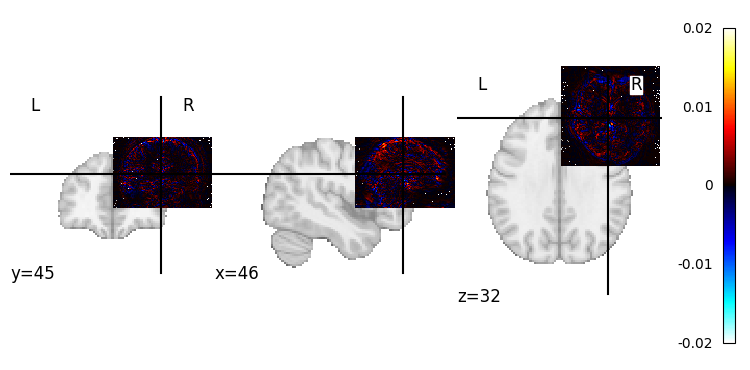

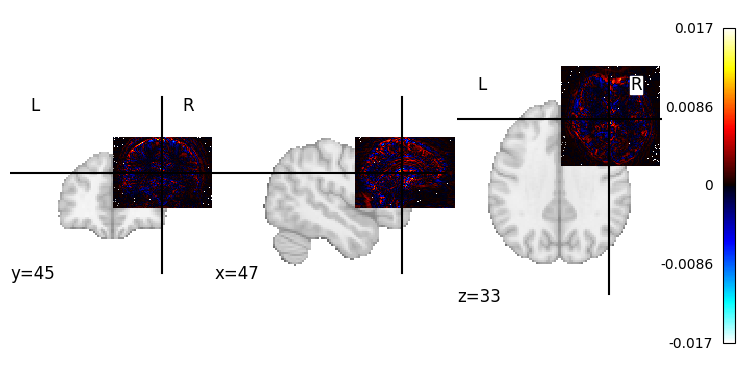

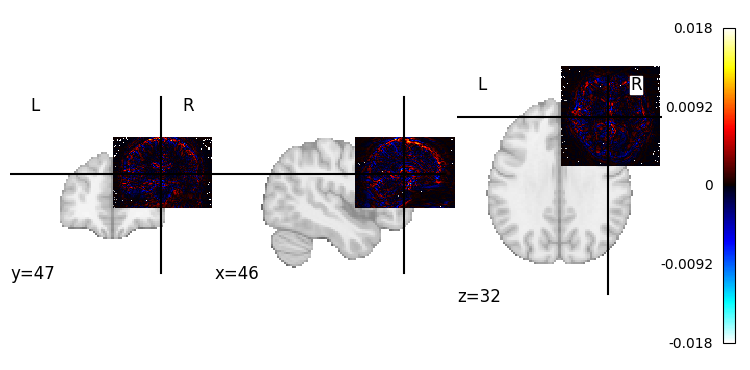

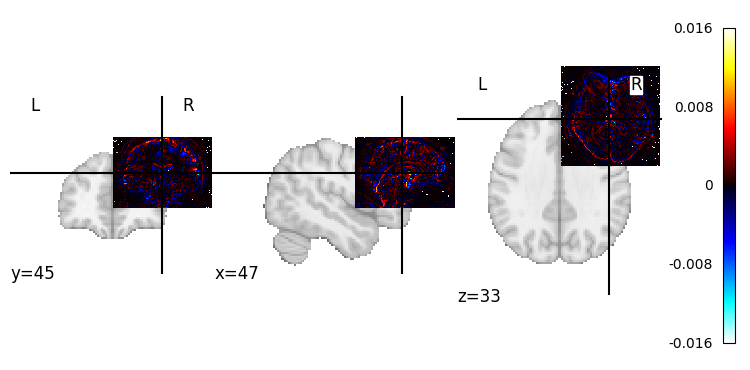

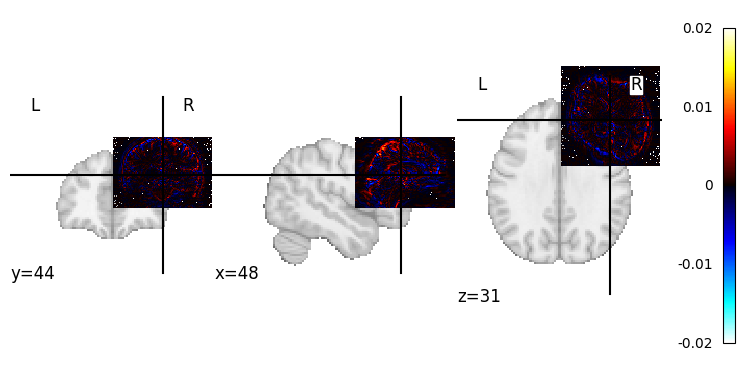

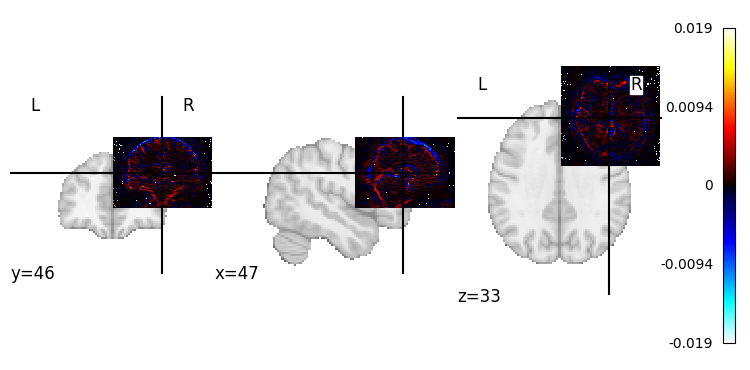

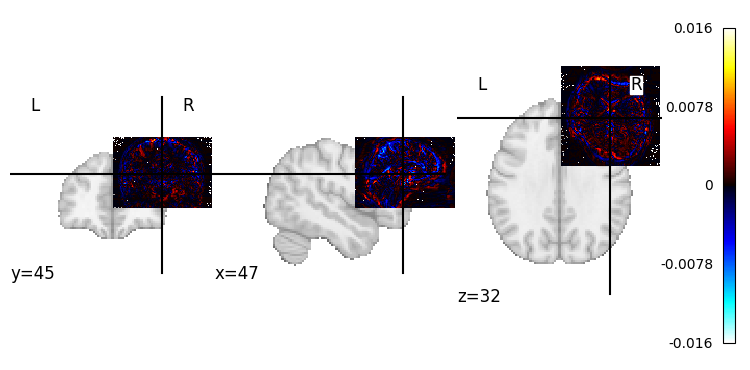

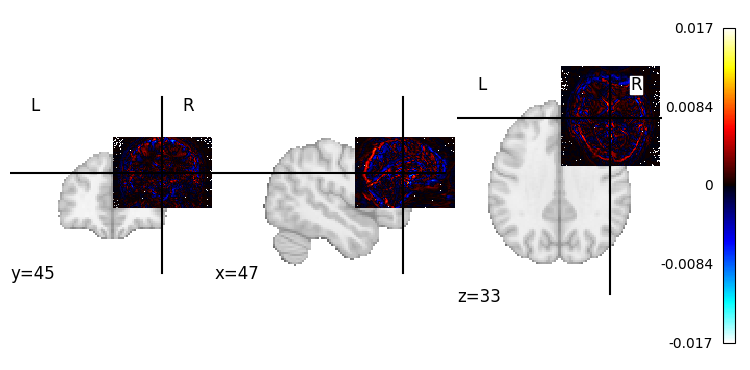

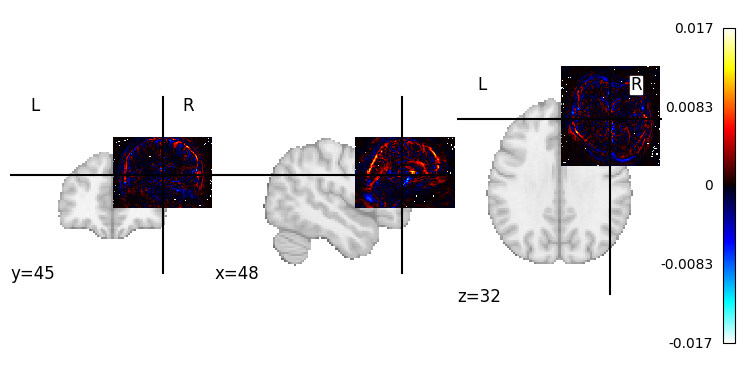

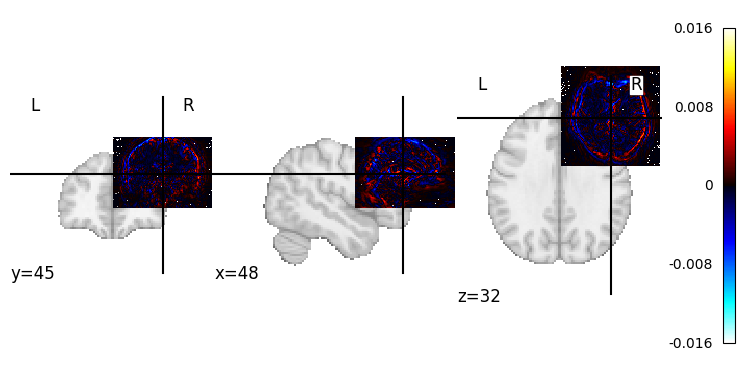

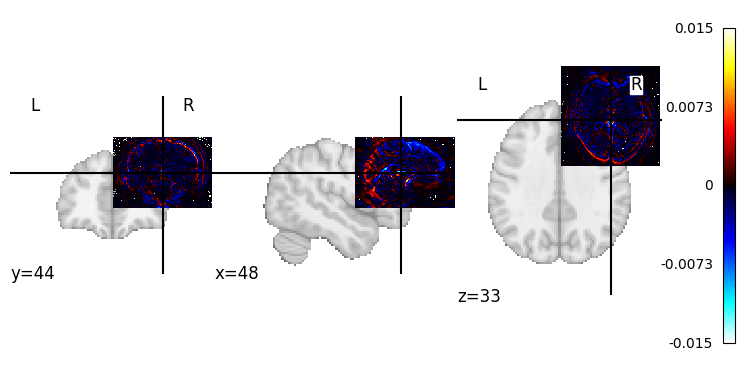

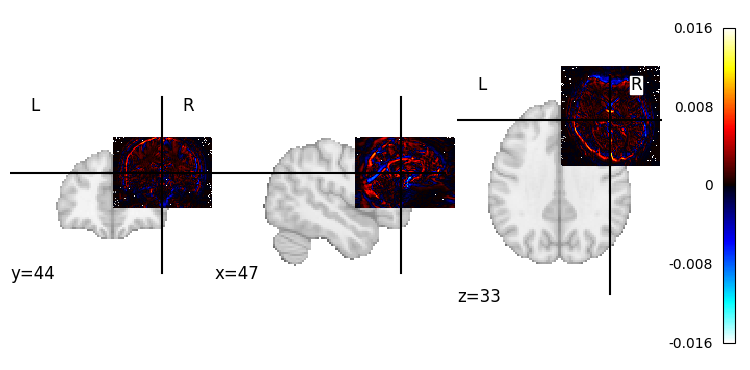

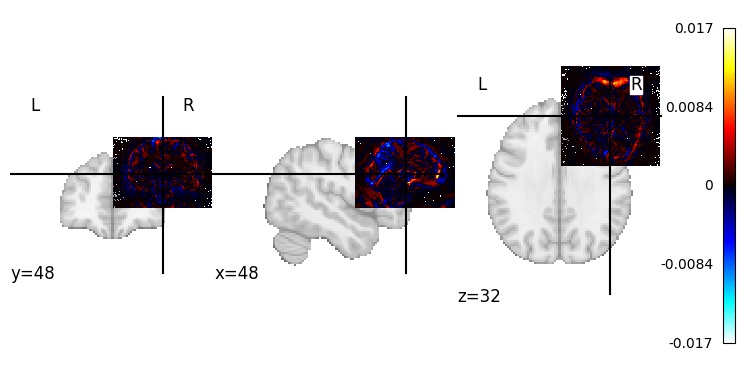

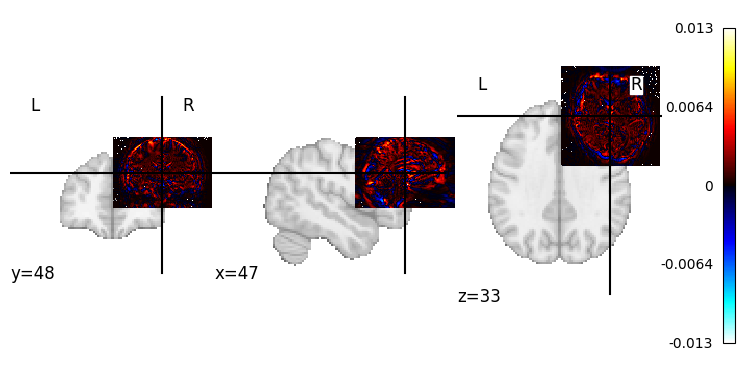

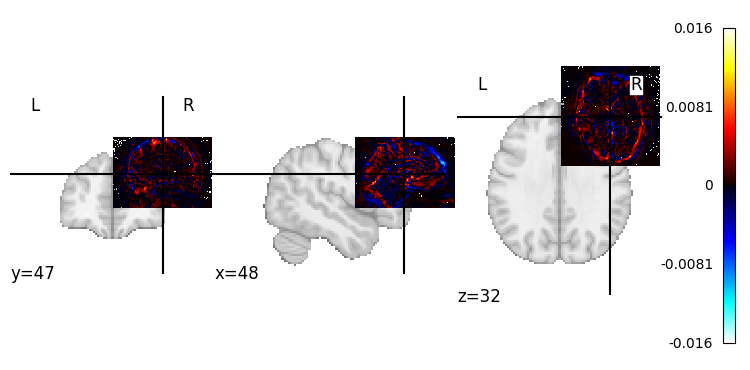

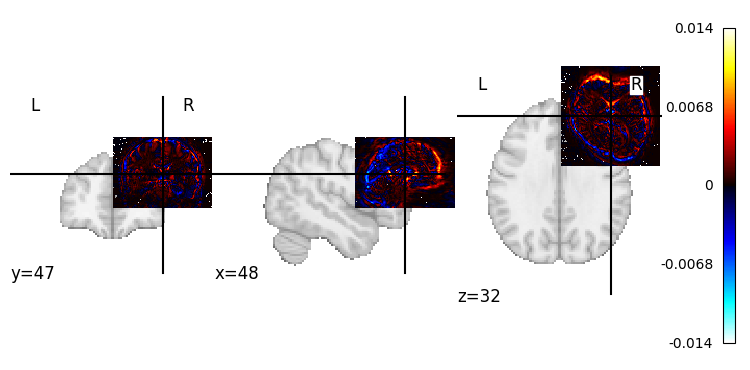

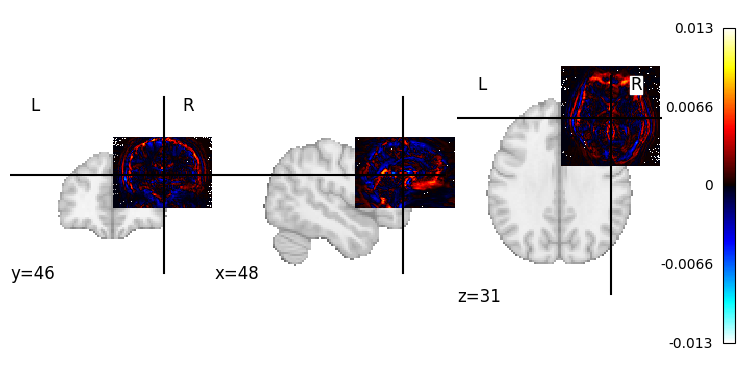

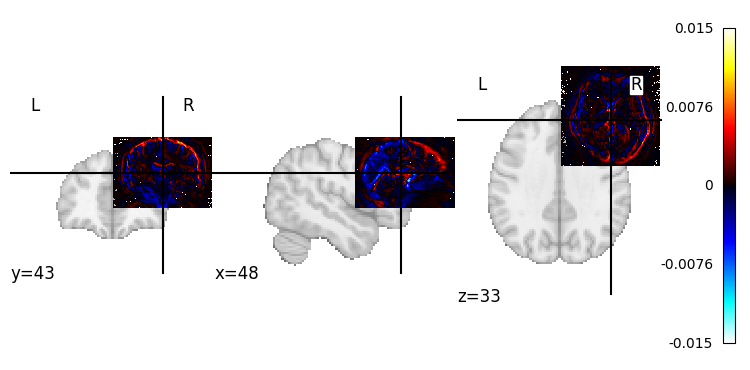

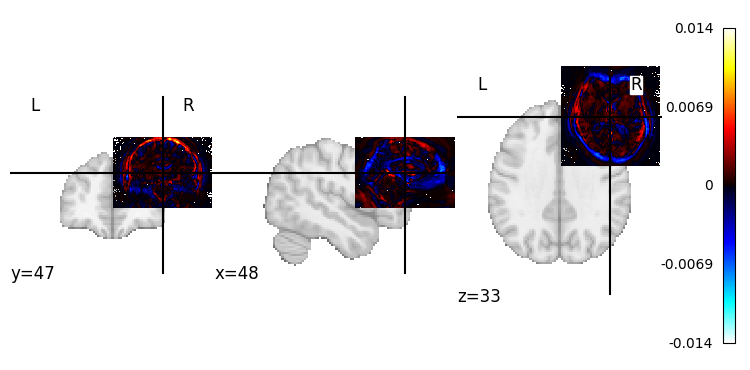

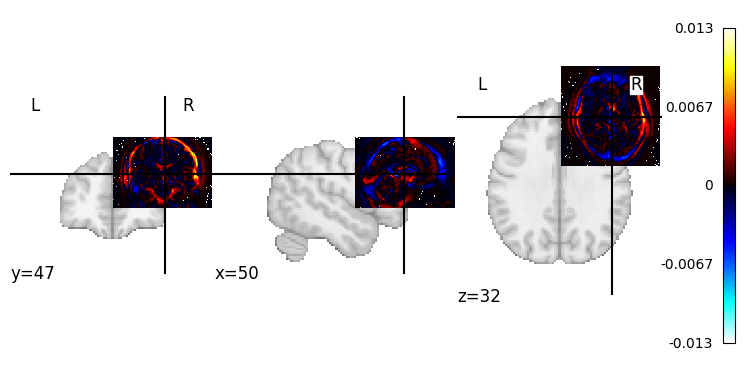

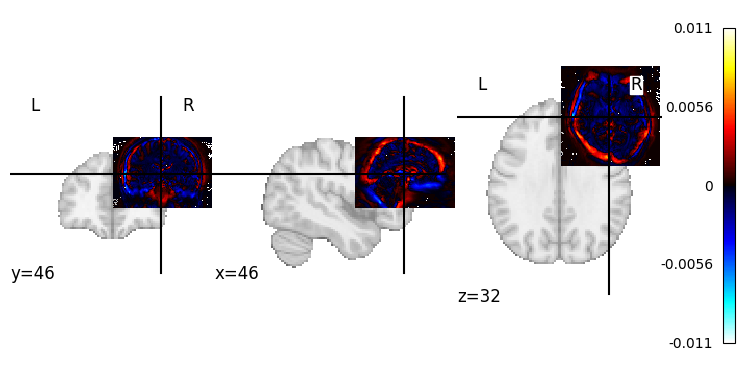

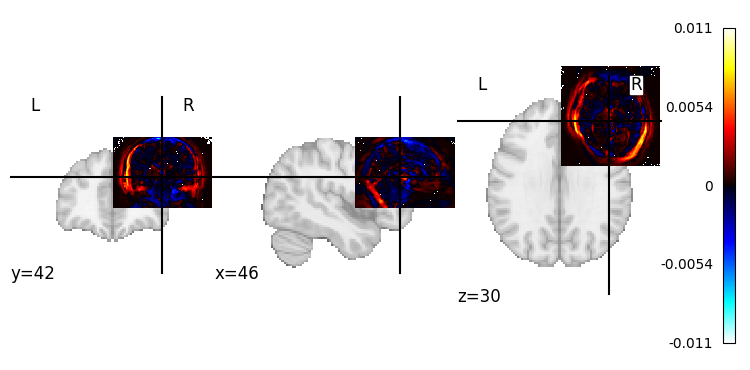

In [ ]:
# from nilearn import plotting
# import nibabel as nib
# for i in reversed(range(30)):
#   img = comp[:,:,:,i].cpu().numpy()
#   img = nib.Nifti1Image(img, affine=np.eye(4))
#   # plotting.plot_stat_map(img, thre)
#   plotting.plot_stat_map(
#           img
#       )

In [ ]:
pca.explained_variance_

tensor([1.2610e+09, 9.6897e+08, 6.9580e+08, 5.8045e+08, 2.8291e+08, 2.4055e+08,
        2.0114e+08, 1.7332e+08, 1.6779e+08, 1.5287e+08, 1.2411e+08, 9.4938e+07,
        7.8503e+07, 7.4947e+07, 4.9243e+07, 4.6714e+07, 2.9128e+07, 2.3326e+07,
        1.9621e+07, 1.7984e+07, 1.7390e+07, 1.6606e+07, 1.5995e+07, 1.4943e+07,
        1.3202e+07, 1.2137e+07, 1.0369e+07, 8.3286e+06, 6.5688e+06, 5.4405e+06],
       device='cuda:0', dtype=torch.float64)